In [1]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# EDA

In [2]:
keys_set = set()
exec_outcome = set()
h_unit_tests = set()
memory_limit = set()
src_id = set()
for file in os.listdir('code_classification_dataset'):
    if file.endswith('.json'):
        with open(os.path.join('code_classification_dataset', file)) as f:
            data = json.load(f)
        keys_set.update(data.keys())
        exec_outcome.update([data['exec_outcome']])
        h_unit_tests.update([data['hidden_unit_tests']])
        memory_limit.update([data['prob_desc_memory_limit']])
        src_id.update([data['src_uid']])

In [3]:
len(keys_set), keys_set

(21,
 {'code_uid',
  'difficulty',
  'exec_outcome',
  'file_name',
  'hidden_unit_tests',
  'lang',
  'lang_cluster',
  'prob_desc_created_at',
  'prob_desc_description',
  'prob_desc_input_from',
  'prob_desc_input_spec',
  'prob_desc_memory_limit',
  'prob_desc_notes',
  'prob_desc_output_spec',
  'prob_desc_output_to',
  'prob_desc_sample_inputs',
  'prob_desc_sample_outputs',
  'prob_desc_time_limit',
  'source_code',
  'src_uid',
  'tags'})

### Keys Descriptions

- **difficulty:** Difficulty rating of the problem indicated by src_uid. The higher the harder.

- **code_uid:** A unique ID for the source code. It is not important for model training.

- **exec_outcome:** A pre-run execution outcome of source code.

- **file_name:** Name of the source jsonl file from where data is loaded. Not important for training.

- **hidden_unit_tests:** a list of unit tests returned as string. use json.loads(hidden_unit_tests) to load the data.

- **lang:** Runtime/Compiler version of the source_code.

- **lang_cluster:** A generic programming language name the value of lang belongs to.

- **prob_desc_created_at:** The Unix timestamp when the problem was released. Use datetime lib in Python to parse it to a human-readable format.

- **prob_desc_description:** Problem description in textual format, math operations are written in latex.

- **prob_desc_input_from:** How the program should take the unit test.

- **prob_desc_input_spec:** How and in what order the input will be given to the program? It also includes the date range, types, and sizes.

- **prob_desc_memory_limit:** Memory limit to solve the problem.

- **prob_desc_notes:** Explanation of sample_inputs & sample_outputs.

- **prob_desc_output_spec:** How the outputs should be printed. Most of the time the unit test results are matched with an exact string match or floating point comparison with a precision boundary.

- **prob_desc_output_to:** Where the program should output the result of the unit test.

- **prob_desc_sample_inputs:** A sample input for the code that is expected to solve the problem described in description.

- **prob_desc_sample_outputs:** The expected output for the sample_input that is expected to solve the problem described in description.

- **prob_desc_time_limit:** Time limit to solve the problem.

- **source_code:** Source code.

- **src_uid:** A specific identifier that shows which problem the code is associated with. This identifier is important for the training of the model. The problem referred to by the src_uid provides a natural description of the problem that the code successfully solved.

- **tags:** List of potential algorithmic techniques required to write the program.

Descriptions taken at : https://github.com/ntunlp/xCodeEval/blob/main/apr.md

In [4]:
exec_outcome, len(exec_outcome), h_unit_tests, len(h_unit_tests), memory_limit, len(memory_limit), len(src_id)

({'PASSED'},
 1,
 {''},
 1,
 {'1024 megabytes',
  '128 megabytes',
  '16 megabytes',
  '216 megabytes',
  '256 mebibytes',
  '256 megabytes',
  '256 мегабайт',
  '265 megabytes',
  '28 megabytes',
  '32 megabytes',
  '384 megabytes',
  '512 MB',
  '512 megabytes',
  '512 мегабайт',
  '64 megabytes',
  '70 megabytes',
  '768 megabytes'},
 17,
 4982)

- Seeing that exec_outcome has just a unique value, we can drop it. The same for hidden_unit_tests.
- Memory limit may be useful, but we need to do more exploration in order to confirm that.
- Problem notes definitely can be useful because they contain information about the problem and about the complexity of the algorithm, which can help us identify the type of the challenge..

Just by reading the descriptions of each feature on our dataset we can already see that some of them are clearly not important as potential predictors for any tag. By doing a little analysis of unique values we can also drop some others. For now it is clear that the following features are not gonna be used as predictors for our classification problem:

- code_uid;
- file_name;
- lang;
- lang_cluster;
- prob_desc_created_at;
- prob_desc_output_to;
- prob_desc_input_from;
- prob_desc_input_spec;
- prob_desc_output_spec;
- exec_outcome;
- hidden_unit_tests;
- src_uid;

For all the others, we should explore a little bit some of them. For sure the problem description and also the source code both could be useful for predicting the kind of problem we are handling. So, we need to explore a bit 11 features and see if they can be useful or not. 

## Creating a dataframe for easier handling of our dataset

In [5]:
data = []
for file in os.listdir('code_classification_dataset'):
    if file.endswith('.json'):
        with open(os.path.join('code_classification_dataset', file)) as f:
            data.append(json.load(f))

data_df = pd.DataFrame(data)

In [6]:
data_df.head()

,prob_desc_time_limit,prob_desc_sample_outputs,src_uid,prob_desc_notes,prob_desc_description,prob_desc_output_spec,prob_desc_input_spec,prob_desc_output_to,prob_desc_input_from,lang,...,difficulty,file_name,code_uid,prob_desc_memory_limit,prob_desc_sample_inputs,exec_outcome,source_code,prob_desc_created_at,tags,hidden_unit_tests
0,1 second,"[""16.000000""]",bb3fc45f903588baf131016bea175a9f,NoteIn the test example we can choose first 4 ...,Iahub has drawn a set of n points in the carte...,Output a single real number — the maximal area...,The first line contains integer n (4 ≤ n ≤ 300...,standard output,standard input,Python 3,...,2100.0,train_048.jsonl,b9da6adb7ff5f00a9127e39974a16d61,256 megabytes,"[""5\n0 0\n0 4\n4 0\n4 4\n2 3""]",PASSED,# calculate convex of polygon v.\n# v is list ...,1377876600,"[geometry, brute force]",
1,2 seconds,"[""1"", ""-1"", ""2"", ""-1"", ""0""]",7898b8258297a6cde8fecb1079172e10,"NoteIn the first test, here is an example plac...",A monopole magnet is a magnet that only has on...,"Output a single integer, the minimum possible ...",The first line contains two integers $$$n$$$ a...,standard output,standard input,PyPy 2,...,2000.0,train_007.jsonl,09b419a2ea7207df6e9f6f972fa83d11,256 megabytes,"[""3 3\n.#.\n###\n##."", ""4 2\n##\n.#\n.#\n##"", ...",PASSED,\n\nfrom math import factorial as fac\nfrom co...,1588775700,"[dsu, constructive algorithms, dfs and similar]",
2,1 second,"[""14"", ""9"", ""3""]",7b12845f668e28b7f18019d5ab5eaec7,NoteIn the first example the optimal sequence ...,Polycarp has prepared $$$n$$$ competitive prog...,Print one integer — the maximum number of prob...,The first line of the input contains one integ...,standard output,standard input,PyPy 3,...,1800.0,train_037.jsonl,99ac0b5c4a37e839f43173d671845752,256 megabytes,"[""18\n2 1 2 10 2 10 10 2 2 1 10 10 10 10 1 1 1...",PASSED,from collections import *\nfrom math import *\...,1542378900,"[sortings, greedy]",
3,4 seconds,"[""3"", ""0"", ""21""]",3875486b0178bf04b3463a15f36f8169,NoteIn the first example three operations are ...,Monocarp has arranged $$$n$$$ colored marbles ...,Print the minimum number of operations Monocar...,The first line contains one integer $$$n$$$ $$...,standard output,standard input,PyPy 3,...,2200.0,train_077.jsonl,13d679e5837ff7ae9285a59d62b8c9a4,256 megabytes,"[""7\n3 4 2 3 4 2 2"", ""5\n20 1 14 10 2"", ""13\n5...",PASSED,# Num of the element\nimport sys\ninput = sys....,1568543700,"[dp, bitmasks]",
4,1 second,"[""3 abc\n2 bc\n1 c\n0 \n1 d"", ""18 abbcd...tw\n...",7d6faccc88a6839822fa0c0ec8c00251,NoteConsider the first example. The longest s...,Some time ago Lesha found an entertaining stri...,In $$$|s|$$$ lines print the lengths of the an...,The only line contains the string $$$s$$$ ($$$...,standard output,standard input,Python 3,...,2700.0,train_011.jsonl,00750c7d58b33d3ac03785c4a39a4ff9,256 megabytes,"[""abcdd"", ""abbcdddeaaffdfouurtytwoo""]",PASSED,s = input().strip();N = len(s)\nif len(s) == 1...,1601827500,"[dp, implementation, greedy, strings]",


### Droping unimportant columns

In [7]:
data_df.drop(columns=['code_uid',
                        'prob_desc_input_from',
                        'prob_desc_output_to',
                        'prob_desc_input_spec',
                        'prob_desc_output_spec',
                        'prob_desc_created_at',
                        'file_name',
                        'exec_outcome',
                        'hidden_unit_tests',
                        'lang',
                        'lang_cluster',
                        ], inplace=True)


### Filtering just the tags defined as important ones

In [8]:
# data_df.to_csv('code_classification_dataset.csv', index=False)

In [9]:
focus_tags = ['math', 'graphs', 'strings', 'number theory','trees', 'geometry', 'games', 'probabilities']

# data_df['tags'] = data_df['tags'].apply(lambda x: list(set([tag if tag in focus_tags else "other" for tag in x])))

data_df.head()


,prob_desc_time_limit,prob_desc_sample_outputs,src_uid,prob_desc_notes,prob_desc_description,difficulty,prob_desc_memory_limit,prob_desc_sample_inputs,source_code,tags
0,1 second,"[""16.000000""]",bb3fc45f903588baf131016bea175a9f,NoteIn the test example we can choose first 4 ...,Iahub has drawn a set of n points in the carte...,2100.0,256 megabytes,"[""5\n0 0\n0 4\n4 0\n4 4\n2 3""]",# calculate convex of polygon v.\n# v is list ...,"[geometry, brute force]"
1,2 seconds,"[""1"", ""-1"", ""2"", ""-1"", ""0""]",7898b8258297a6cde8fecb1079172e10,"NoteIn the first test, here is an example plac...",A monopole magnet is a magnet that only has on...,2000.0,256 megabytes,"[""3 3\n.#.\n###\n##."", ""4 2\n##\n.#\n.#\n##"", ...",\n\nfrom math import factorial as fac\nfrom co...,"[dsu, constructive algorithms, dfs and similar]"
2,1 second,"[""14"", ""9"", ""3""]",7b12845f668e28b7f18019d5ab5eaec7,NoteIn the first example the optimal sequence ...,Polycarp has prepared $$$n$$$ competitive prog...,1800.0,256 megabytes,"[""18\n2 1 2 10 2 10 10 2 2 1 10 10 10 10 1 1 1...",from collections import *\nfrom math import *\...,"[sortings, greedy]"
3,4 seconds,"[""3"", ""0"", ""21""]",3875486b0178bf04b3463a15f36f8169,NoteIn the first example three operations are ...,Monocarp has arranged $$$n$$$ colored marbles ...,2200.0,256 megabytes,"[""7\n3 4 2 3 4 2 2"", ""5\n20 1 14 10 2"", ""13\n5...",# Num of the element\nimport sys\ninput = sys....,"[dp, bitmasks]"
4,1 second,"[""3 abc\n2 bc\n1 c\n0 \n1 d"", ""18 abbcd...tw\n...",7d6faccc88a6839822fa0c0ec8c00251,NoteConsider the first example. The longest s...,Some time ago Lesha found an entertaining stri...,2700.0,256 megabytes,"[""abcdd"", ""abbcdddeaaffdfouurtytwoo""]",s = input().strip();N = len(s)\nif len(s) == 1...,"[dp, implementation, greedy, strings]"


In [10]:
from collections import Counter

# Count all non-focus tags
non_focus_counter = Counter()
for tag_list in data_df["tags"]:
    for tag in tag_list:
        if tag not in focus_tags:
            non_focus_counter[tag] += 1

In [11]:
# Seeing count of non-focus tags
non_focus_counter

Counter({'greedy': 1743,
         'implementation': 1597,
         'constructive algorithms': 1036,
         'dp': 984,
         'brute force': 837,
         'data structures': 783,
         'sortings': 671,
         'binary search': 567,
         'dfs and similar': 508,
         'two pointers': 320,
         'combinatorics': 273,
         'bitmasks': 256,
         'dsu': 176,
         'shortest paths': 144,
         'interactive': 120,
         'hashing': 108,
         'divide and conquer': 94,
         '*special': 58,
         'flows': 42,
         'matrices': 38,
         'ternary search': 36,
         'graph matchings': 36,
         'string suffix structures': 30,
         '2-sat': 20,
         'expression parsing': 18,
         'meet-in-the-middle': 17,
         'fft': 16,
         'chinese remainder theorem': 10,
         'schedules': 4})

In [12]:
focus_counter = Counter()
for tag_list in data_df["tags"]:
    for tag in tag_list:
        if tag in focus_tags:
            focus_counter[tag] += 1

In [13]:
focus_counter

Counter({'math': 1409,
         'graphs': 542,
         'strings': 422,
         'number theory': 350,
         'trees': 324,
         'geometry': 166,
         'games': 105,
         'probabilities': 92})

We will consider all tags with frequencies lower than 92 as 'other' and we will keep the other tags as they are. 

In [14]:
non_other_labels = [tag for tag in non_focus_counter if non_focus_counter[tag] >= 92]
non_other_labels += focus_tags
non_other_labels, len(non_other_labels)

(['brute force',
  'dsu',
  'constructive algorithms',
  'dfs and similar',
  'sortings',
  'greedy',
  'dp',
  'bitmasks',
  'implementation',
  'data structures',
  'combinatorics',
  'two pointers',
  'binary search',
  'shortest paths',
  'hashing',
  'divide and conquer',
  'interactive',
  'math',
  'graphs',
  'strings',
  'number theory',
  'trees',
  'geometry',
  'games',
  'probabilities'],
 25)

In [15]:
def rename_tags(tags):
    new_tags = set()
    for tag in tags:
        if tag in non_other_labels:
            new_tags.add(tag)
        else:
            new_tags.add('other')
    return list(new_tags)
data_df['new_tags'] = data_df['tags'].apply(rename_tags)

### Seeing Distribution of each Tag

/var/folders/f3/d1mj1kk95jqdvc_576kbwhl00000gn/T/ipykernel_3630/570142672.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_count.keys(), y=tag_count.values(), palette="crest")


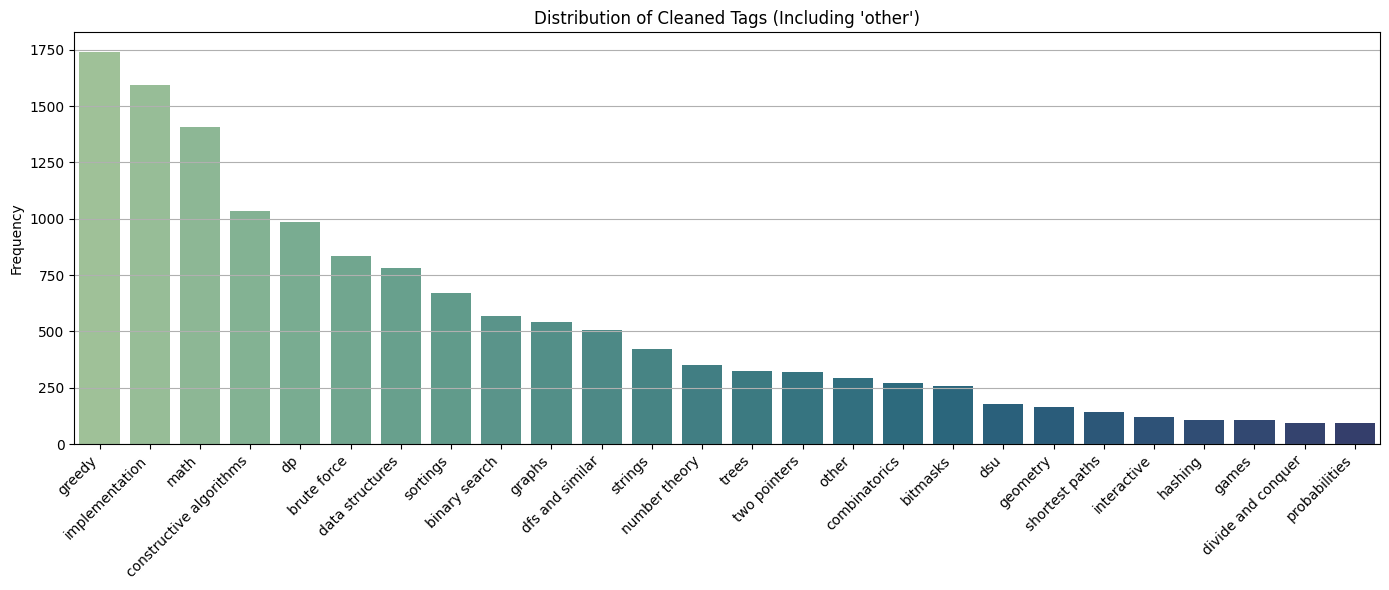

In [16]:
tag_count = Counter()
for tag_list in data_df["new_tags"]:
    for tag in tag_list:  
        tag_count[tag] += 1

# sort the tag count dictionary
tag_count = dict(sorted(tag_count.items(), key=lambda item: item[1], reverse=True))

# Plot the distribution
plt.figure(figsize=(14, 6))
sns.barplot(x=tag_count.keys(), y=tag_count.values(), palette="crest")
plt.title("Distribution of Cleaned Tags (Including 'other')")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Number of tags per problem

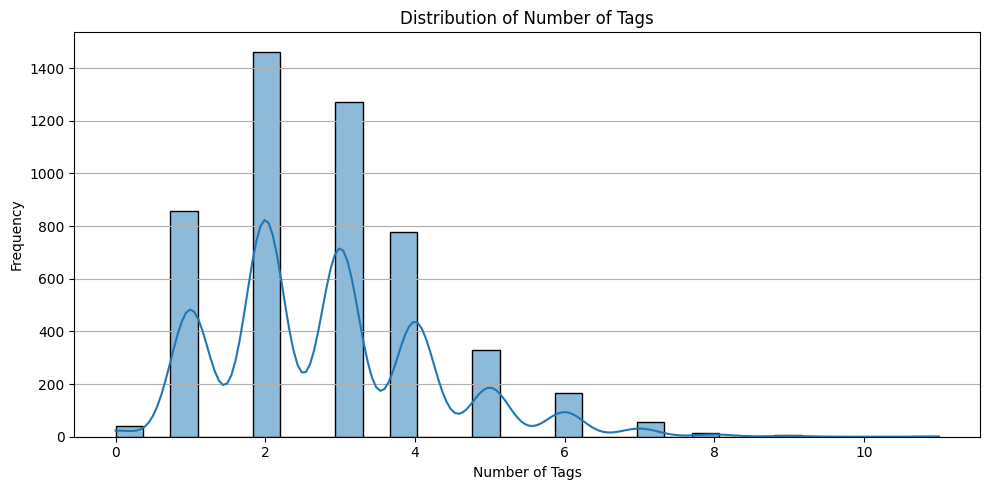

In [17]:
data_df['number_tags'] = data_df['new_tags'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(data_df['number_tags'], bins=30, kde=True)
plt.title("Distribution of Number of Tags")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [18]:
data_df['number_tags'].describe(), data_df['number_tags'].value_counts()

(count    4982.000000
 mean        2.792654
 std         1.426990
 min         0.000000
 25%         2.000000
 50%         3.000000
 75%         4.000000
 max        11.000000
 Name: number_tags, dtype: float64,
 number_tags
 2     1463
 3     1271
 1      858
 4      776
 5      331
 6      166
 7       55
 0       41
 8       15
 9        5
 11       1
 Name: count, dtype: int64)

In [19]:
# dropping problems with no tags
data_df = data_df[data_df['number_tags'] > 0]
data_df.shape

(4941, 12)

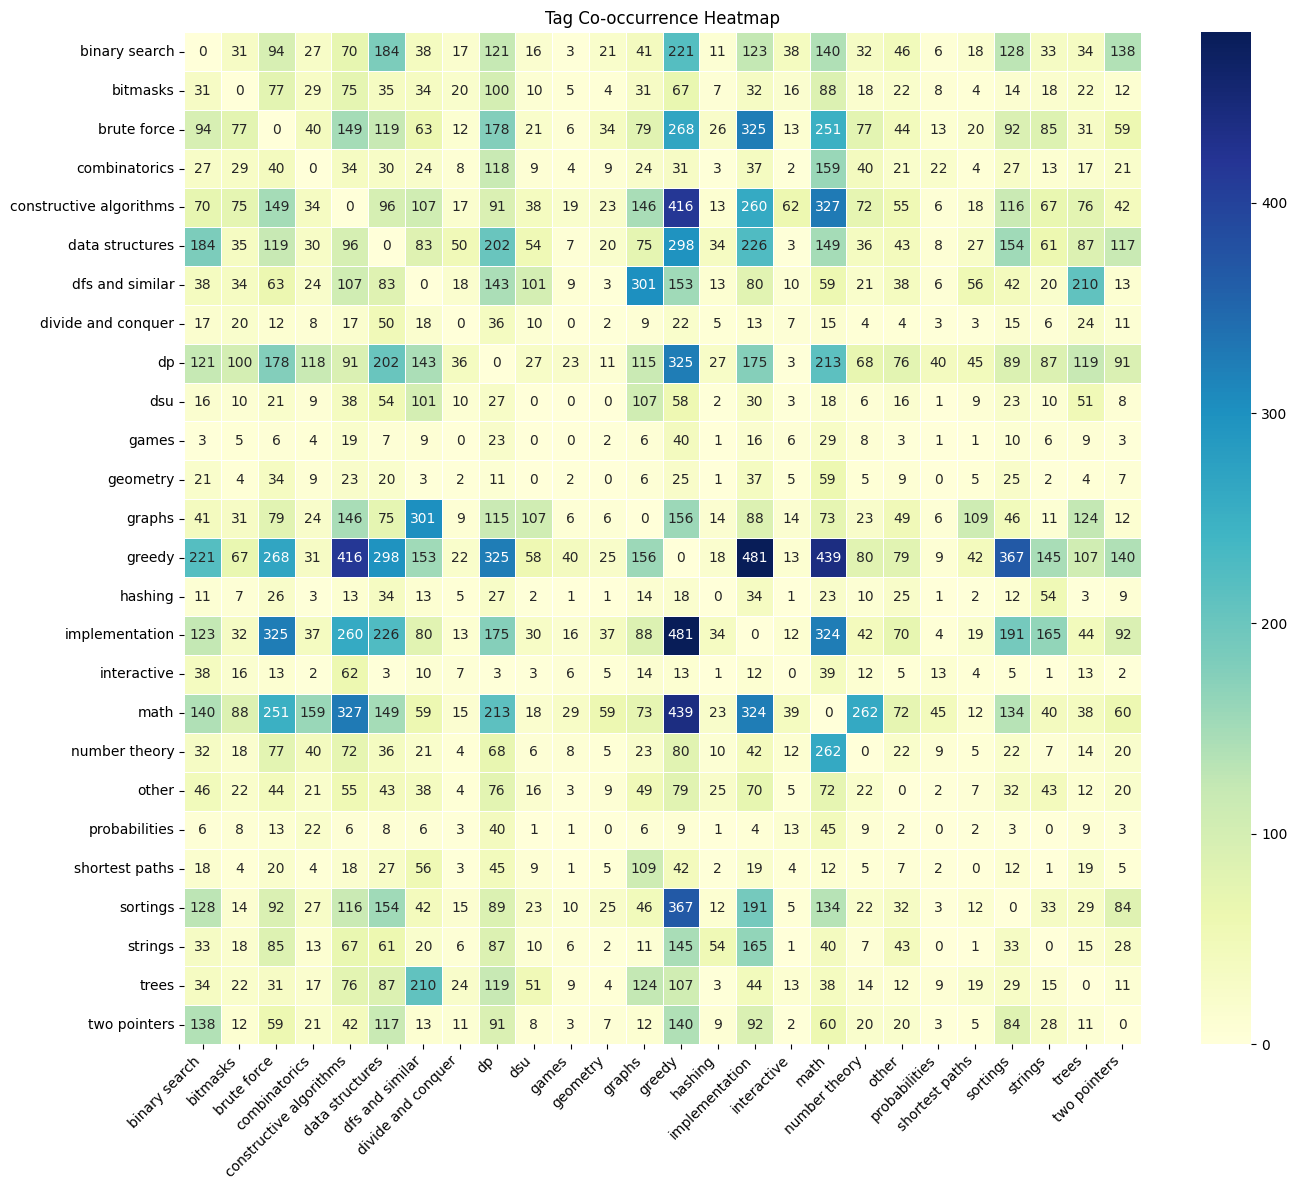

In [20]:
### Seeing heatmap of tags co-occurence

# Create multi-hot encoded DataFrame for cleaned tags
all_cleaned_tags = sorted(set(tag for tags in data_df["new_tags"] for tag in tags))
multi_hot = pd.DataFrame(0, index=data_df.index, columns=all_cleaned_tags)

for idx, tags in data_df["new_tags"].items():
    for tag in tags:
        multi_hot.at[idx, tag] = 1

# Compute co-occurrence matrix
co_occurrence = multi_hot.T.dot(multi_hot)

# Zero out diagonal (self-co-occurrence is not informative)
np.fill_diagonal(co_occurrence.values, 0)

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(co_occurrence, cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)
plt.title("Tag Co-occurrence Heatmap")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Seeing Description/Code lengths.

In [21]:
# === Description & Code Length Features ===
data_df["desc_length_chars"] = data_df["prob_desc_description"].fillna("").apply(len)
data_df["desc_length_words"] = data_df["prob_desc_description"].fillna("").apply(lambda x: len(x.split()))
data_df["code_length_lines"] = data_df["source_code"].fillna("").apply(lambda x: len(x.splitlines()))
data_df["code_length_chars"] = data_df["source_code"].fillna("").apply(len)

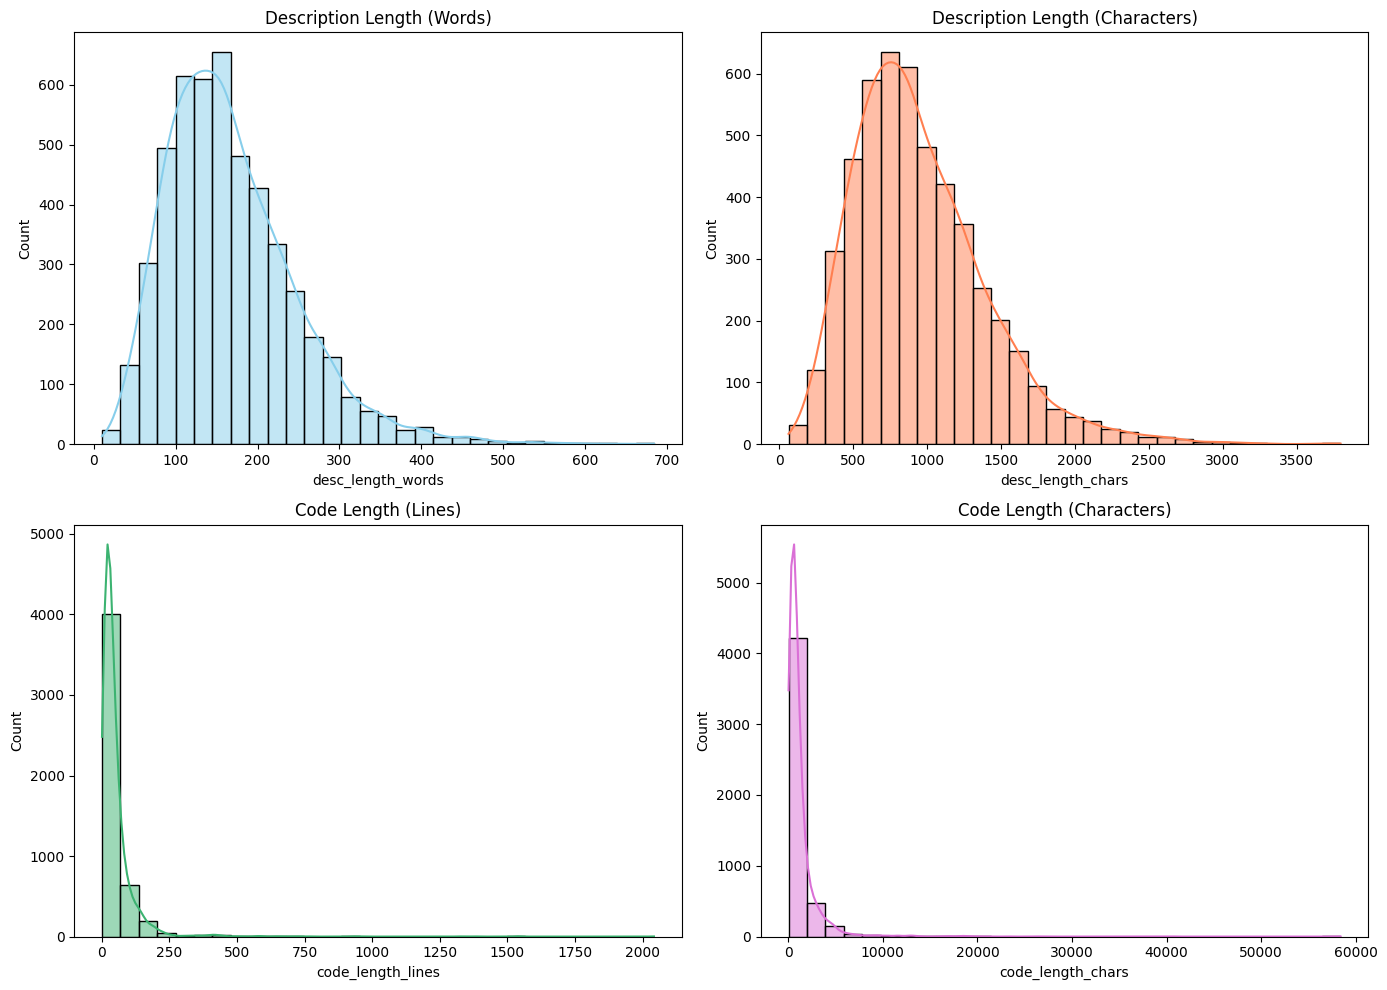

(       desc_length_words  desc_length_chars
 count        4941.000000        4941.000000
 mean          167.292046         950.814208
 std            79.471223         452.203976
 min            10.000000          63.000000
 25%           110.000000         626.000000
 50%           155.000000         874.000000
 75%           211.000000        1197.000000
 max           684.000000        3796.000000,
        code_length_lines  code_length_chars
 count        4941.000000        4941.000000
 mean           50.984821        1227.188221
 std            78.493255        2175.776534
 min             1.000000          28.000000
 25%            18.000000         365.000000
 50%            32.000000         685.000000
 75%            58.000000        1319.000000
 max          2042.000000       58387.000000)

In [22]:
# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(data_df["desc_length_words"], bins=30, kde=True, ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title("Description Length (Words)")

sns.histplot(data_df["desc_length_chars"], bins=30, kde=True, ax=axes[0, 1], color="coral")
axes[0, 1].set_title("Description Length (Characters)")

sns.histplot(data_df["code_length_lines"], bins=30, kde=True, ax=axes[1, 0], color="mediumseagreen")
axes[1, 0].set_title("Code Length (Lines)")

sns.histplot(data_df["code_length_chars"], bins=30, kde=True, ax=axes[1, 1], color="orchid")
axes[1, 1].set_title("Code Length (Characters)")

plt.tight_layout()
plt.show()

# Summary statistics
desc_stats = data_df[["desc_length_words", "desc_length_chars"]].describe()
code_stats = data_df[["code_length_lines", "code_length_chars"]].describe()
desc_stats, code_stats

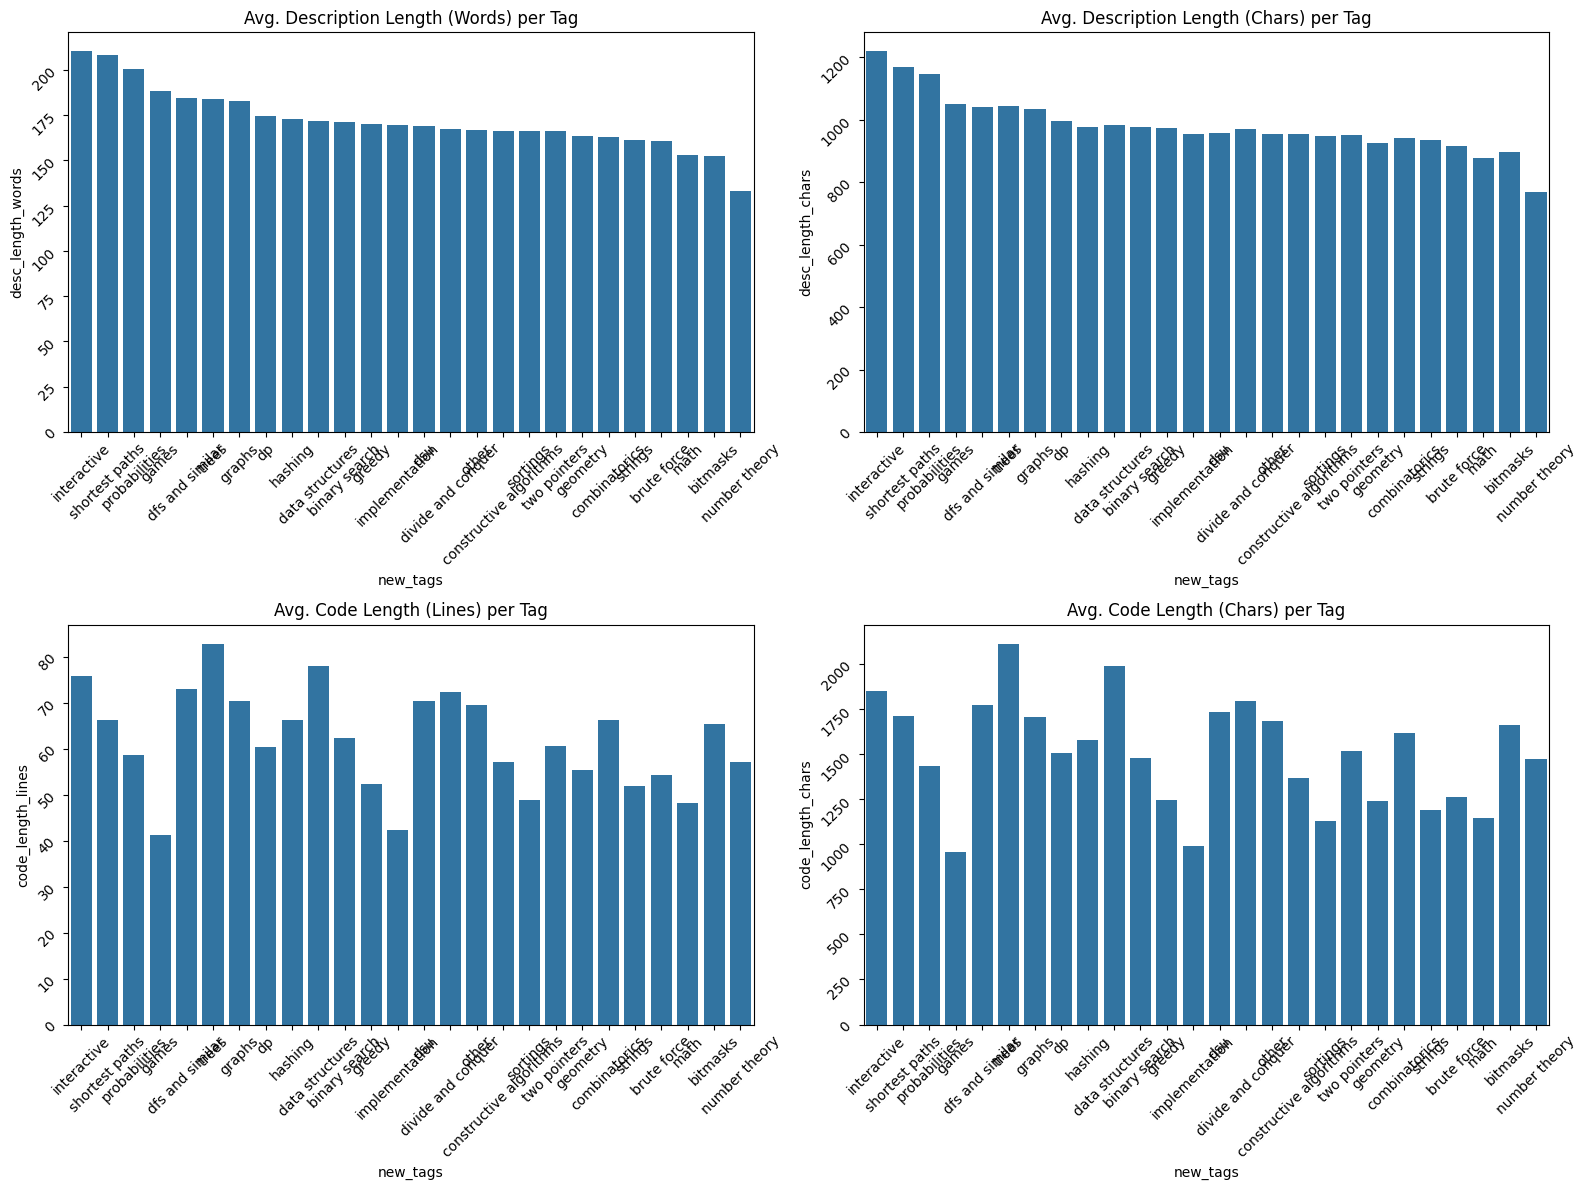

,desc_length_words,desc_length_chars,code_length_lines,code_length_chars
new_tags,,,,
interactive,210.2,1219.2,75.9,1852.3
shortest paths,208.4,1168.4,66.1,1714.3
probabilities,200.2,1147.4,58.6,1438.4
games,188.6,1050.7,41.2,957.0
dfs and similar,184.5,1040.3,72.9,1775.3
trees,184.0,1043.1,82.8,2114.1
graphs,182.8,1034.7,70.2,1708.0
dp,174.7,996.5,60.4,1505.9
hashing,172.9,976.5,66.2,1581.9


In [25]:
# Group by tag and compute average lengths
tag_length_stats = data_df.explode("new_tags").groupby("new_tags")[
    ["desc_length_words", "desc_length_chars", "code_length_lines", "code_length_chars"]
].mean().sort_values("desc_length_words", ascending=False)

import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(data=tag_length_stats, x=tag_length_stats.index, y="desc_length_words", ax=axes[0, 0])
axes[0, 0].set_title("Avg. Description Length (Words) per Tag")
axes[0, 0].tick_params(rotation=45)

sns.barplot(data=tag_length_stats, x=tag_length_stats.index, y="desc_length_chars", ax=axes[0, 1])
axes[0, 1].set_title("Avg. Description Length (Chars) per Tag")
axes[0, 1].tick_params(rotation=45)

sns.barplot(data=tag_length_stats, x=tag_length_stats.index, y="code_length_lines", ax=axes[1, 0])
axes[1, 0].set_title("Avg. Code Length (Lines) per Tag")
axes[1, 0].tick_params(rotation=45)

sns.barplot(data=tag_length_stats, x=tag_length_stats.index, y="code_length_chars", ax=axes[1, 1])
axes[1, 1].set_title("Avg. Code Length (Chars) per Tag")
axes[1, 1].tick_params(rotation=45)

plt.tight_layout()
plt.show()

tag_length_stats.round(1)

By this plosts we can see that in average, the descriptions are quite similar in terms of length. So the length is not a key feature for predicting the tag. In another hand, the code length vary a lot with different tags, so it may be more useful as a feature. 

### Analysing memory and time limits

In [34]:
def extract_seconds(text):
    if isinstance(text, str) and "second" in text:
        try:
            return float(text.split()[0])
        except ValueError:
            return None
    return None

def extract_megabytes(text):
    if isinstance(text, str) and "megabyte" in text:
        try:
            return float(text.split()[0])
        except ValueError:
            return None
    return None

extract_megabytes(data_df.loc[0, 'prob_desc_memory_limit']), extract_seconds(data_df.loc[0, 'prob_desc_time_limit'])

(256.0, 1.0)

In [35]:
data_df["time_limit_sec"] = data_df["prob_desc_time_limit"].apply(extract_seconds)
data_df["memory_limit_mb"] = data_df["prob_desc_memory_limit"].apply(extract_megabytes)

In [36]:
data_df.head()

,prob_desc_time_limit,prob_desc_sample_outputs,src_uid,prob_desc_notes,prob_desc_description,difficulty,prob_desc_memory_limit,prob_desc_sample_inputs,source_code,tags,new_tags,number_tags,desc_length_chars,desc_length_words,code_length_lines,code_length_chars,time_limit_sec,memory_limit_mb
0,1 second,"[""16.000000""]",bb3fc45f903588baf131016bea175a9f,NoteIn the test example we can choose first 4 ...,Iahub has drawn a set of n points in the carte...,2100.0,256 megabytes,"[""5\n0 0\n0 4\n4 0\n4 4\n2 3""]",# calculate convex of polygon v.\n# v is list ...,"[geometry, brute force]","[brute force, geometry]",2,474,78,76,1651,1.0,256.0
1,2 seconds,"[""1"", ""-1"", ""2"", ""-1"", ""0""]",7898b8258297a6cde8fecb1079172e10,"NoteIn the first test, here is an example plac...",A monopole magnet is a magnet that only has on...,2000.0,256 megabytes,"[""3 3\n.#.\n###\n##."", ""4 2\n##\n.#\n.#\n##"", ...",\n\nfrom math import factorial as fac\nfrom co...,"[dsu, constructive algorithms, dfs and similar]","[constructive algorithms, dsu, dfs and similar]",3,1493,268,292,5982,2.0,256.0
2,1 second,"[""14"", ""9"", ""3""]",7b12845f668e28b7f18019d5ab5eaec7,NoteIn the first example the optimal sequence ...,Polycarp has prepared $$$n$$$ competitive prog...,1800.0,256 megabytes,"[""18\n2 1 2 10 2 10 10 2 2 1 10 10 10 10 1 1 1...",from collections import *\nfrom math import *\...,"[sortings, greedy]","[greedy, sortings]",2,925,153,22,388,1.0,256.0
3,4 seconds,"[""3"", ""0"", ""21""]",3875486b0178bf04b3463a15f36f8169,NoteIn the first example three operations are ...,Monocarp has arranged $$$n$$$ colored marbles ...,2200.0,256 megabytes,"[""7\n3 4 2 3 4 2 2"", ""5\n20 1 14 10 2"", ""13\n5...",# Num of the element\nimport sys\ninput = sys....,"[dp, bitmasks]","[bitmasks, dp]",2,1002,170,61,1900,4.0,256.0
4,1 second,"[""3 abc\n2 bc\n1 c\n0 \n1 d"", ""18 abbcd...tw\n...",7d6faccc88a6839822fa0c0ec8c00251,NoteConsider the first example. The longest s...,Some time ago Lesha found an entertaining stri...,2700.0,256 megabytes,"[""abcdd"", ""abbcdddeaaffdfouurtytwoo""]",s = input().strip();N = len(s)\nif len(s) == 1...,"[dp, implementation, greedy, strings]","[greedy, strings, implementation, dp]",4,820,140,9,395,1.0,256.0
